In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
!ls /content/MyDrive/MyDrive/Dataset/IRD_UMMISCO/FinalDataSet/Models/

best_inception_resnetv2_unet_model.h5  fine_tuned_best_inception_resnetv2_unet_model.h5
best_vgg19_fcn8_model.h5	       fine_tuned_best_vgg19_fcn8_model.h5


In [ ]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.math import log , reduce_mean
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Add

In [ ]:
!pip install patchify
from patchify import patchify, unpatchify

Classe Building: 18678298 pixels
Classe Land: 19913065 pixels
Classe Road: 217153 pixels
Classe Vegetation: 6306932 pixels
Classe Water: 3516177 pixels
Classe cultivated field: 15695400 pixels
Classe uncultivated field: 4911630 pixels
Classe Football_field: 641566 pixels


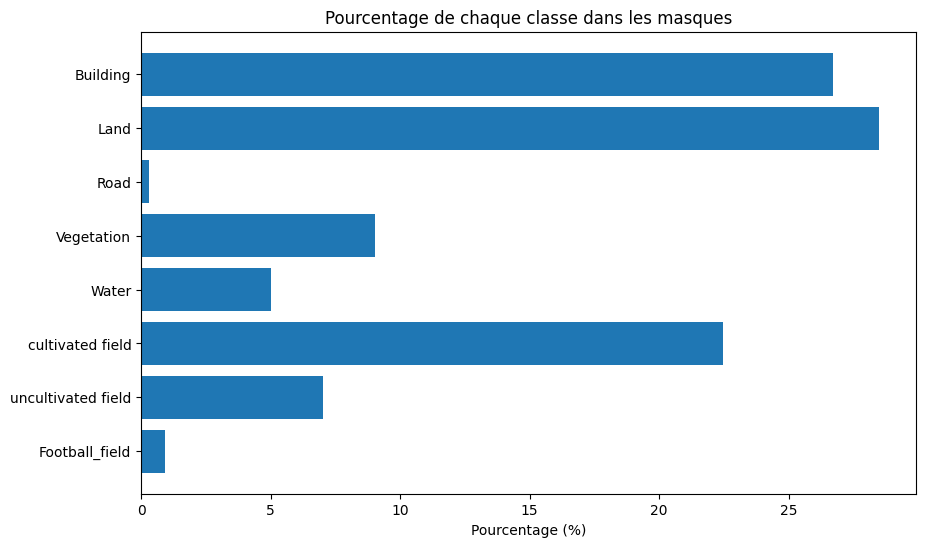

Classe Building: 26.73%
Classe Land: 28.50%
Classe Road: 0.31%
Classe Vegetation: 9.03%
Classe Water: 5.03%
Classe cultivated field: 22.46%
Classe uncultivated field: 7.03%
Classe Football_field: 0.92%


In [ ]:
root_directory='/content/MyDrive/MyDrive/Dataset/IRD_UMMISCO/FinalDataSet/data'

class_colors = {
    'Building': (60, 16, 152), #Violet
    'Land': (132, 41, 246), #Mauve
    'Road': (110, 193, 228),  # Bleu clair
    'Vegetation': (254, 221, 58), #jaune
    'Water':(226, 169, 41), #jaune foncé
    'cultivated field': (0, 255, 35), #♦vert #00FF23
    'uncultivated field': (255, 0, 0), #Rouge
    'Football_field': (0, 0, 255)
}

# Dictionnaire pour stocker le nombre de pixels par classe
class_pixel_counts = {cls: 0 for cls in class_colors.keys()}

# Parcourir les fichiers de masque dans le répertoire
for path, _, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        masks.sort()
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                mask = cv2.imread(os.path.join(path, mask_name), 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                mask = np.array(mask)

                # Compter le nombre de pixels par classe dans ce masque
                for cls, color in class_colors.items():
                    class_mask = np.all(mask == color, axis=-1)
                    class_pixel_count = np.sum(class_mask)
                    class_pixel_counts[cls] += class_pixel_count

# Afficher le nombre de pixels de chaque classe
for cls, pixel_count in class_pixel_counts.items():
    print(f"Classe {cls}: {pixel_count} pixels")

# Calculer le nombre total de pixels dans tous les masques
total_pixels = sum(class_pixel_counts.values())

# Calculer les pourcentages de chaque classe
class_percentages = {cls: count / total_pixels * 100 for cls, count in class_pixel_counts.items()}

# Créer un histogramme des pourcentages de chaque classe
classes = list(class_percentages.keys())
percentages = list(class_percentages.values())

plt.figure(figsize=(10, 6))
plt.barh(classes, percentages)
plt.xlabel('Pourcentage (%)')
plt.title('Pourcentage de chaque classe dans les masques')
plt.gca().invert_yaxis()  # Inverser l'axe y pour avoir la classe principale en haut
plt.show()

# Afficher les pourcentages de chaque classe
for cls, percentage in class_percentages.items():
    print(f"Classe {cls}: {percentage:.2f}%")

In [ ]:
#The first problem is the size/shape of the images; we need to either crop or resize.
#dataset is so small and data augmentation may work in this case. But this method has already been done by another contributor and giving great results.

#reading images and resizing them into the same shape
root_directory='/content/MyDrive/MyDrive/Dataset/IRD_UMMISCO/FinalDataSet/data'
patch_size = 256

scaler = MinMaxScaler()

image_dataset = []
mask_dataset = []

for path,subdirs,files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        images.sort()

        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg") or image_name.endswith(".png"):
                #Get image paths  "print(path+"/"+image_name)"

                image = cv2.imread(path+"/"+image_name,1)
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,SIZE_X,SIZE_Y))
                image = np.array(image)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i,j,0,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        image_dataset.append(single_patch_img)

    if dirname == 'masks':
        masks = os.listdir(path)
        masks.sort()
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):

                mask = cv2.imread(path+'/'+mask_name, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i,j,0,:,:]
                        mask_dataset.append(single_patch_mask)


KeyboardInterrupt: ignored

In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

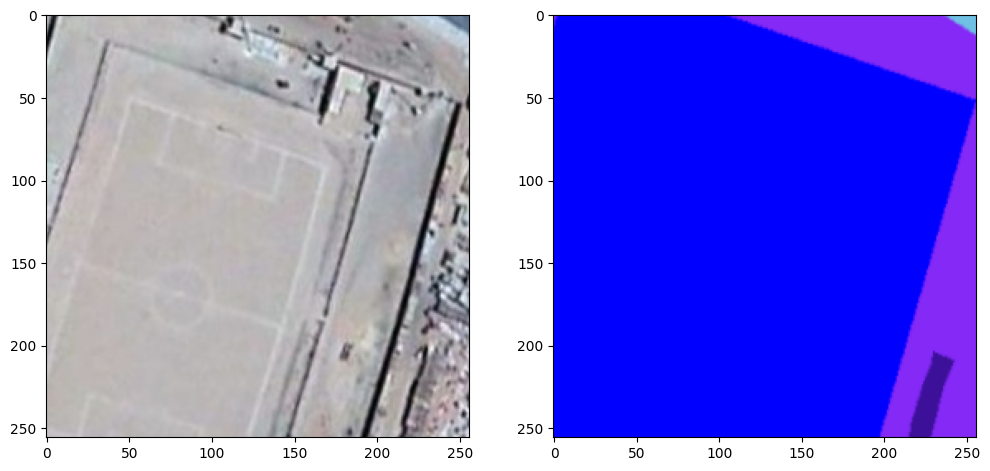

In [ ]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [ ]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152 Violet

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228 bleu clair

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246 Mauve

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58 jaune clair

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41 Jaune foncé

Cultivated_Field = '#00FF23'.lstrip('#')
Cultivated_Field = np.array(tuple(int(Cultivated_Field[i:i+2], 16) for i in (0, 2, 4))) #0,255,35 vert

Uncultivated_Field = '#FF0000'.lstrip('#')
Uncultivated_Field = np.array(tuple(int(Uncultivated_Field[i:i+2], 16) for i in (0, 2, 4))) #255, 0, 0 Rouge

Football_field = '#0000FF'.lstrip('#')
Football_field = np.array(tuple(int(Football_field[i:i+2], 16) for i in (0, 2, 4))) #0, 0, 255 Bleu


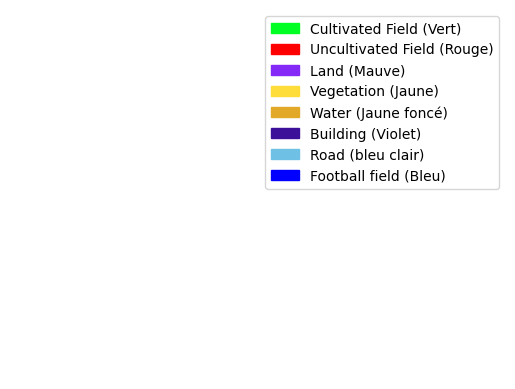

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Créer une figure et des axes
fig, ax = plt.subplots()

# Définir des proxies de légende pour les couleurs
land_patch = mpatches.Patch(color=Land/255.0, label='Land (Mauve)')
vegetation_patch = mpatches.Patch(color=Vegetation/255.0, label='Vegetation (Jaune)')
water_patch = mpatches.Patch(color=Water/255.0, label='Water (Jaune foncé)')
Cultivated_Field_patch = mpatches.Patch(color=Cultivated_Field/255.0, label='Cultivated Field (Vert)')
Uncultivated_Field_patch = mpatches.Patch(color=Uncultivated_Field/255.0, label='Uncultivated Field (Rouge)')
building_patch = mpatches.Patch(color=Building/255.0, label='Building (Violet)')
road_patch = mpatches.Patch(color=Road/255.0, label='Road (bleu clair)')
football_patch = mpatches.Patch(color=Football_field/255.0, label='Football field (Bleu)')

# Afficher les légendes avec les proxies de légende
ax.legend(handles=[Cultivated_Field_patch,Uncultivated_Field_patch,land_patch, vegetation_patch, water_patch, building_patch, road_patch, football_patch])

# Masquer les axes
ax.axis('off')

# Afficher le graphique
plt.show()


In [ ]:
label = single_patch_mask

def rgb_to_2D_label(label):

    label_seg = np.zeros(label.shape, dtype=np.uint8)

    label_seg[np.all(label == Land, axis = -1)] = 0
    label_seg[np.all(label == Vegetation, axis = -1)] = 1
    label_seg[np.all(label == Water, axis = -1)] = 2

    label_seg[np.all(label == Road, axis = -1)] = 3
    label_seg[np.all(label == Building, axis = -1)] = 4
    label_seg[np.all(label == Cultivated_Field, axis = -1)] = 5

    label_seg[np.all(label == Uncultivated_Field, axis = -1)] = 6
    label_seg[np.all(label == Football_field, axis = -1)] = 7

    label_seg = label_seg[:,:,0]

    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

In [ ]:
labels = np.array(labels)
labels.shape

(906, 256, 256)

In [ ]:
labels_cat = to_categorical(labels)
labels_cat.shape

(965, 256, 256, 8)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset,
                                                    labels_cat,
                                                    test_size = 0.10,
                                                    random_state = 42)

In [ ]:
np.savez('/content/MyDrive/MyDrive/Dataset/IRD_UMMISCO/FinalDataSet/data_preprocessed_ird_2.npz', X_train=X_train, X_test=X_test,y_train=y_train,y_test=y_test)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(868, 256, 256, 3)
(97, 256, 256, 3)
(868, 256, 256, 8)
(97, 256, 256, 8)


In [ ]:
# Vérification de la disponibilité du GPU
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU disponible")
    strategy = tf.distribute.OneDeviceStrategy("GPU:0")  # Utiliser le GPU
else:
    print("GPU non disponible")
    strategy = tf.distribute.OneDeviceStrategy("CPU")    # Utiliser le CPU

GPU disponible


In [ ]:
!ls '/content/MyDrive/MyDrive/Dataset/IRD_UMMISCO/FinalDataSet/'

 2019.jpg				 dakar6.jpg		       Test	 'Tile 3'
 2020.jpg				 data			      'Tile 1'	 'Tile 4'
 5_2019.jpg				 data_preprocessed_ird_2.npz  'Tile 10'  'Tile 5'
 6_2019.jpg				 data_preprocessed_ird.npz    'Tile 11'  'Tile 6'
 best_inception_resnetv2_unet_model.h5	 Ferlo.jpg		      'Tile 12'  'Tile 7'
 dakar1.jpg				 galsen.jpg		      'Tile 13'  'Tile 8'
 dakar2.jpg				 Matam.jpg		      'Tile 14'  'Tile 9'
 dakar3.jpg				 Matam.png		      'Tile 15'   Ziguinchor1.jpg
 dakar4.jpg				 Models			      'Tile 16'   Ziguinchor2.jpg
 dakar5.jpg				 st1.jpg		      'Tile 2'	  ziguinchor.jpg


In [ ]:
with strategy.scope():
  loaded_data = np.load('/content/MyDrive/MyDrive/Dataset/IRD_UMMISCO/FinalDataSet/data_preprocessed_ird.npz')
  X_train = loaded_data['X_train']
  X_test = loaded_data['X_test']
  y_train = loaded_data['y_train']
  y_test = loaded_data['y_test']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(815, 256, 256, 3)
(91, 256, 256, 3)
(815, 256, 256, 8)
(91, 256, 256, 8)


In [ ]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [ ]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.5 MB/s eta 0:00:00


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from tensorflow.keras.layers import  Rescaling
from keras import backend as K

In [ ]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

def jaccard_loss(y_true, y_pred, smooth=1e-5):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2))
    union = tf.reduce_sum(y_true + y_pred, axis=(1, 2)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou

In [ ]:
from keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, Dropout, ZeroPadding2D, Concatenate
from keras.applications import InceptionResNetV2
from keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def inception_resnetv2_unet(input_shape, num_classes):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output           ## (256 x 256)

    s2 = encoder.get_layer("activation").output        ## (128 x 128)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    s3 = encoder.get_layer("activation_3").output      ## (64 x 64)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (256 x 256)

    s4 = encoder.get_layer("activation_74").output      ## (31 x 31)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (256 x 256)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (256 x 256)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (256 x 256)
    d2 = decoder_block(d1, s3, 256)                     ## (256 x 256)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (256 x 256)

    """ Output """
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(dropout)

    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model


In [ ]:
from keras.applications.vgg19 import VGG19
from keras.layers import Activation, Add, Conv2D, Conv2DTranspose, Input, Conv2DTranspose, Add
from keras.models import Model

def vgg19_fcn_8(classes=8, input_shape=(256, 256, 3)):
    # Charger le modèle VGG19 pré-entraîné
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)

    # Geler les couches inférieures
    for layer in vgg.layers:
        layer.trainable = False

    # Récupérer les sorties des couches pool3 et pool4
    pool3 = vgg.get_layer('block3_pool').output
    pool4 = vgg.get_layer('block4_pool').output

    # Continuer avec le reste du code
    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(vgg.get_layer('block5_pool').output)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)

    conv_8 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
    conv_9 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)

    deconv_7 = Conv2DTranspose(classes, kernel_size=(2, 2), strides=(2, 2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])

    deconv_8 = Conv2DTranspose(classes, kernel_size=(2, 2), strides=(2, 2))(add_1)
    add_2 = Add()([deconv_8, conv_9])
    deconv_9 = Conv2DTranspose(classes, kernel_size=(8, 8), strides=(8, 8))(add_2)

    output_layer = Activation('softmax')(deconv_9)

    model = Model(inputs=vgg.input, outputs=output_layer)

    return model


In [ ]:
!ls /content/MyDrive/MyDrive/Dataset/IRD_UMMISCO/FinalDataSet/Models

best_inception_resnetv2_unet_model.h5  fine_tuned_best_inception_resnetv2_unet_model.h5
best_vgg19_fcn8_model.h5	       fine_tuned_best_vgg19_fcn8_model.h5


In [ ]:
from keras.models import load_model
with strategy.scope():
  model = load_model('/content/MyDrive/MyDrive/Dataset/IRD_UMMISCO/FinalDataSet/Models/fine_tuned_best_inception_resnetv2_unet_model.h5',compile=False)

  for layer in model.layers[:-12]:
    layer.trainable = False

In [ ]:
model.summary()

Model: "InceptionResNetV2-UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_n

In [ ]:
metrics = ["accuracy", jaccard_coef]

In [ ]:
def get_deep_learning_model():
  input_shape = (image_height,image_width,image_channels)
  return vgg19_fcn_8(total_classes, input_shape)

In [ ]:
with strategy.scope():
  model = get_deep_learning_model()

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [ ]:
from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
weights = [1/6]*8

dice_loss = sm.losses.DiceLoss(class_weights = weights)


focal_loss = sm.losses.CategoricalFocalLoss()


total_loss = dice_loss + focal_loss

In [ ]:
import tensorflow as tf

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from keras.optimizers import Adam
with strategy.scope():
  model.compile(optimizer=Adam(learning_rate=0.001), loss=total_loss, metrics=metrics)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [ ]:
import gc
gc.collect()

136

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
                 #EarlyStopping(patience=25,  # Patience should be larger than the one in ReduceLROnPlateau
                              #min_delta=0.00001),
                 #DVCLiveCallback(save_dvc_exp=True),
                 #ModelCheckpoint('/content/MyDrive/MyDrive/IRD_UMMISCO/last_inception_resnetv2_unet_model_lv3.h5'),
                 ModelCheckpoint('/content/MyDrive/MyDrive/IRD_UMMISCO/best_vgg19_fcn8_model.h5',
                                 save_best_only=True)
                 ]

with strategy.scope():
  model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=100,
                          validation_data=(X_test, y_test),
                          shuffle=False,
                          callbacks = callbacks
                            )

Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 1.0342 - accuracy: 0.2122 - jaccard_coef: 0.0850

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 41s 444ms/step - loss: 1.0342 - accuracy: 0.2122 - jaccard_coef: 0.0850 - val_loss: 1.0154 - val_accuracy: 0.3290 - val_jaccard_coef: 0.1473
Epoch 2/100
51/51 [==============================] - 11s 217ms/step - loss: 0.9921 - accuracy: 0.4475 - jaccard_coef: 0.2122 - val_loss: 0.9713 - val_accuracy: 0.6130 - val_jaccard_coef: 0.3386
Epoch 3/100
51/51 [==============================] - 20s 387ms/step - loss: 0.9550 - accuracy: 0.6628 - jaccard_coef: 0.3809 - val_loss: 0.9496 - val_accuracy: 0.7098 - val_jaccard_coef: 0.4350
Epoch 4/100
51/51 [==============================] - 12s 238ms/step - loss: 0.9364 - accuracy: 0.7505 - jaccard_coef: 0.4927 - val_loss: 0.9379 - val_accuracy: 0.7521 - val_jaccard_coef: 0.5068
Epoch 5/100
51/51 [==============================] - 19s 369ms/step - loss: 0.9269 - accuracy: 0.7861 - jaccard_coef: 0.5542 - val_loss: 0.9317 - val_accuracy: 0.7740 - val_jaccard_coef: 0.5448
Epoch 6/100
51/51 [=======================

In [ ]:
import gc
gc.collect()

17590

In [ ]:
model.save("/content/MyDrive/MyDrive/Dataset/IRD_UMMISCO/FinalDataSet/model_unet_version_2.h5")

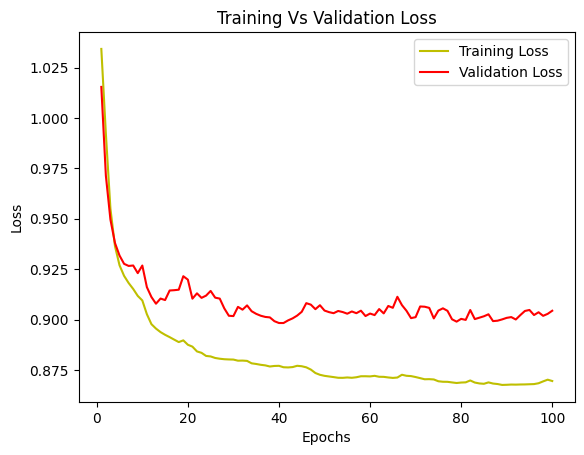

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

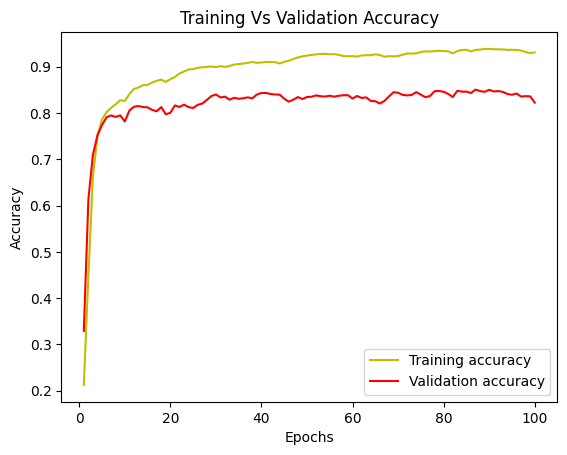

In [ ]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label="Training accuracy")
plt.plot(epochs, val_accuracy, 'r', label="Validation accuracy")
plt.title("Training Vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

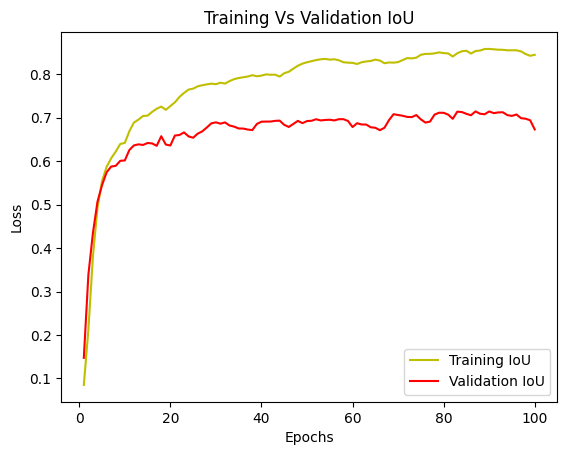

In [ ]:
jaccard_coef = model_history.history['jaccard_coef']
val_jaccard_coef = model_history.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

3/3 [==============================] - 14s 3s/step


In [ ]:
import matplotlib.pyplot as plt
import random
import matplotlib.colors as mcolors

In [ ]:
class_colors = [Land, Vegetation, Water, Road, Building, Cultivated_Field, Uncultivated_Field,Football_field]

# Normalisation des couleurs RVB pour qu'elles soient dans la plage [0, 1]
class_colors = [(r / 255.0, g / 255.0, b / 255.0) for (r, g, b) in class_colors]
cmap = mcolors.ListedColormap(class_colors)

6


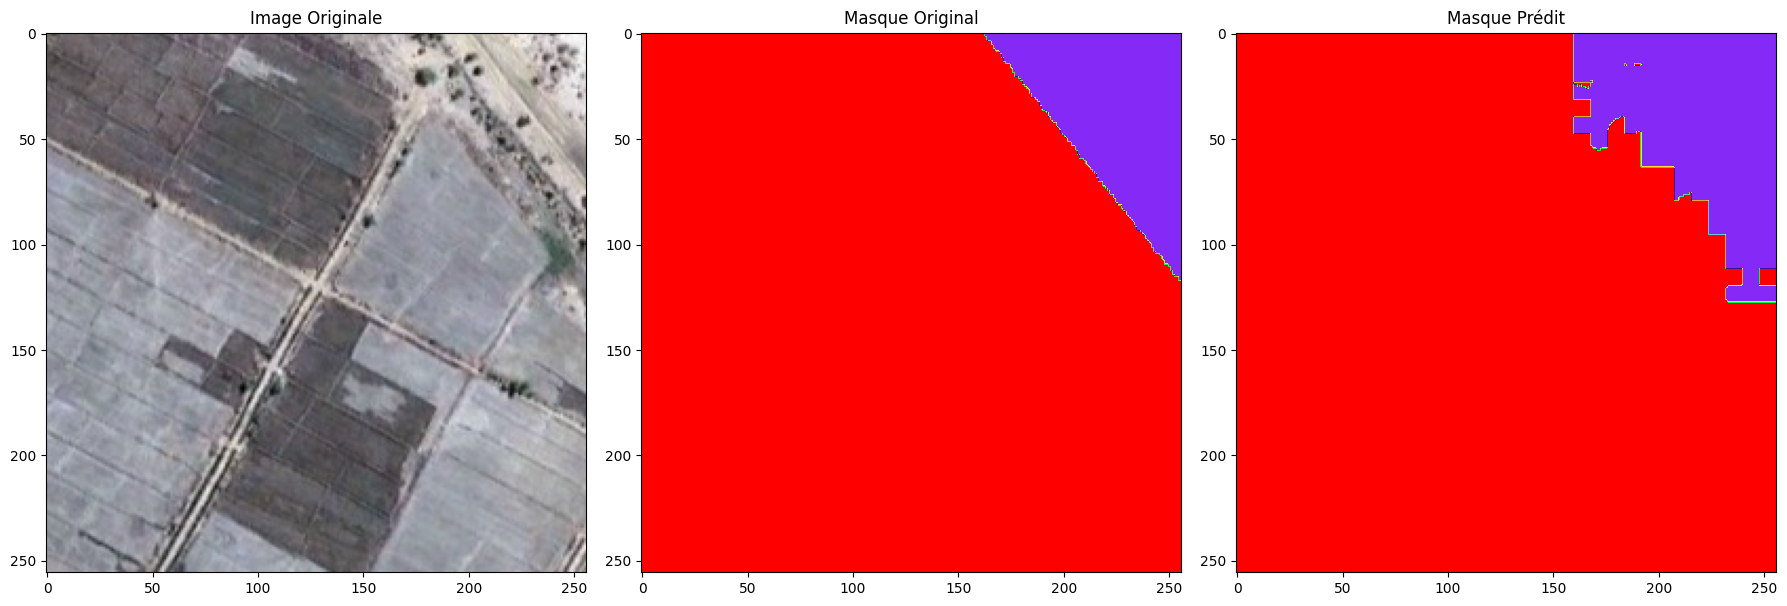

In [ ]:
# Sélectionnez un échantillon aléatoire pour l'affichage
sample_index = random.randint(0, len(X_test) - 1)
print(sample_index)
# Récupérez l'image de test et le masque prédit correspondant
image = X_test[sample_index]
original_mask = y_test_argmax[sample_index]
predicted_mask = y_pred_argmax[sample_index]

# Créez une figure avec deux sous-plots pour afficher l'image et le masque
plt.figure(figsize=(18, 6))


plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Image Originale")

plt.subplot(1, 3, 2)
plt.imshow(original_mask, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
plt.title("Masque Original")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)  # Utilisez une colormap appropriée pour la segmentation
plt.title("Masque Prédit")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, jaccard_score

# Calcul du coefficient de Jaccard (IoU)
iou = jaccard_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted')

# Calcul et affichage du rapport de classification (précision, rappel, F1-score)
class_names = ['Land', 'Vegetation', 'Water', 'Road', 'Building', 'Cultivated_Field', 'Uncultivated_Field', 'Football_field']
report = classification_report(y_test_argmax.flatten(), y_pred_argmax.flatten(), target_names=class_names)
print("Rapport de Classification :")
print(report)

# Affichage du coefficient de Jaccard (IoU)
print(f"Coefficient de Jaccard (IoU) : {iou}")


Rapport de Classification :
                    precision    recall  f1-score   support

              Land       0.86      0.73      0.79   1966058
        Vegetation       0.58      0.91      0.71    310818
             Water       0.86      0.91      0.88    114112
              Road       0.70      0.83      0.76     15560
          Building       0.88      0.88      0.88   1113422
  Cultivated_Field       0.87      0.86      0.87   1528163
Uncultivated_Field       0.73      0.85      0.79    887728
    Football_field       0.82      0.84      0.83     27915

          accuracy                           0.82   5963776
         macro avg       0.79      0.85      0.81   5963776
      weighted avg       0.83      0.82      0.82   5963776

Coefficient de Jaccard (IoU) : 0.703439443113961


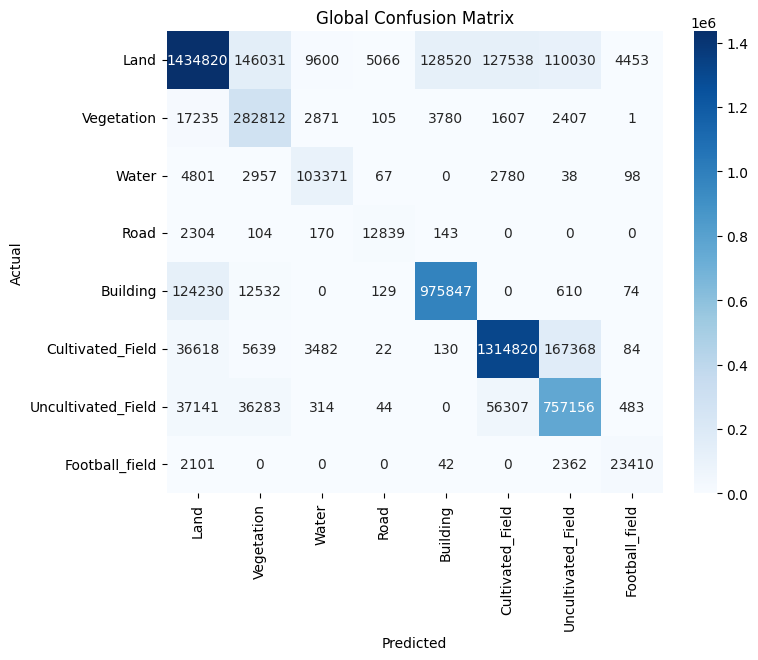

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_names = ['Land', 'Vegetation', 'Water', 'Road', 'Building', 'Cultivated_Field', 'Uncultivated_Field', 'Football_field']
global_confusion = confusion_matrix(y_test_argmax.flatten(), y_pred_argmax.flatten())

plt.figure(figsize=(8, 6))
sns.heatmap(global_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Global Confusion Matrix")
plt.show()


In [ ]:
import tensorflow as tf
from keras.models import load_model
import numpy as np

# Charger le modèle pré-entrainé
model = load_model('/content/MyDrive/MyDrive/Dataset/IRD_UMMISCO/FinalDataSet/Models/fine_tuned_best_inception_resnetv2_unet_model.h5',compile=False)

In [ ]:
def custom_round(number):
    decimal_part = number - int(number)
    if decimal_part < 0.5:
        return int(number)
    else:
        return int(number) + 1

In [ ]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

3/3 [==============================] - 37s 6s/step


In [ ]:
from sklearn.metrics import classification_report, jaccard_score

# Calcul du coefficient de Jaccard (IoU)
iou = jaccard_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted')

# Calcul et affichage du rapport de classification (précision, rappel, F1-score)
class_names = ['Land', 'Vegetation', 'Water', 'Road', 'Building', 'Cultivated_Field', 'Uncultivated_Field','Football_field']
report = classification_report(y_test_argmax.flatten(), y_pred_argmax.flatten(), target_names=class_names)
print("Rapport de Classification :")
print(report)

# Affichage du coefficient de Jaccard (IoU)
print(f"Coefficient de Jaccard (IoU) : {iou}")


Rapport de Classification :
                    precision    recall  f1-score   support

              Land       0.95      0.93      0.94   1799366
        Vegetation       0.92      0.96      0.94    435898
             Water       0.97      0.95      0.96    144559
              Road       0.93      0.97      0.95     11755
          Building       0.95      0.97      0.96    952722
  Cultivated_Field       0.98      0.97      0.98   1699822
Uncultivated_Field       0.97      0.99      0.98    898437
    Football_field       0.96      0.98      0.97     21217

          accuracy                           0.96   5963776
         macro avg       0.95      0.97      0.96   5963776
      weighted avg       0.96      0.96      0.96   5963776

Coefficient de Jaccard (IoU) : 0.925550998146283


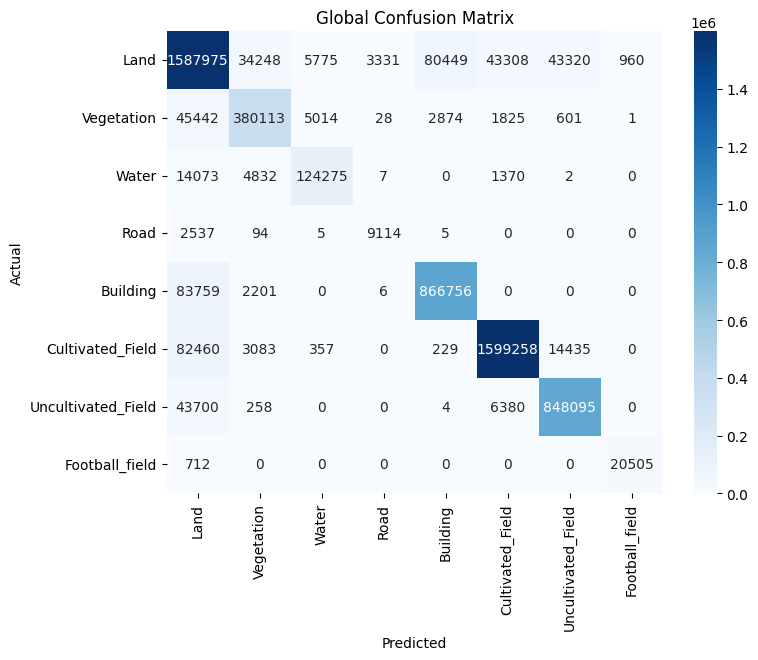

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_names = ['Land', 'Vegetation', 'Water', 'Road', 'Building', 'Cultivated_Field', 'Uncultivated_Field','Football_field']
global_confusion = confusion_matrix(y_test_argmax.flatten(), y_pred_argmax.flatten())

plt.figure(figsize=(8, 6))
sns.heatmap(global_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Global Confusion Matrix")
plt.show()

In [ ]:
confusion = global_confusion

tp = np.diag(confusion)
fp = np.sum(confusion, axis=0) - tp
fn = np.sum(confusion, axis=1) - tp
tn = np.sum(confusion) - (tp + fp + fn)

# Calcul des totaux globaux
total_tp = np.sum(tp)
total_fp = np.sum(fp)
total_fn = np.sum(fn)
total_tn = np.sum(tn)

# Calcul des pourcentages globaux
total_tp_percentage = total_tp / (total_tp + total_fp) * 100
total_fp_percentage = total_fp / (total_tp + total_fp) * 100
total_tn_percentage = total_tn / (total_fn + total_tn) * 100
total_fn_percentage = total_fn / (total_fn + total_tn) * 100

print(f"Pourcentage global de Vrais Positifs (TP) : {total_tp_percentage}%")
print(f"Pourcentage global de Faux Positifs (FP) : {total_fp_percentage}%")
print(f"Pourcentage global de Vrais Négatifs (TN) : {total_tn_percentage}%")
print(f"Pourcentage global de Faux Négatifs (FN) : {total_fn_percentage}%")

NameError: ignored

In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_test_argmax.flatten(), y_pred_argmax.flatten())
kappa

0.885501915953613

In [ ]:
from sklearn.metrics import accuracy_score

oa = accuracy_score(y_test_argmax.flatten(), y_pred_argmax.flatten())
oa

0.911518306522579